# ProbNum Quickstart

Follow the steps below to get started with ProbNum and learn about its basic functionality.

In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Plotting
import matplotlib.pyplot as plt
plt.style.use('../probnum.mplstyle')

## Installation

You can install ProbNum using `pip` (or `pip3`).
```bash
pip install probnum
```
Alternatively, you can install the latest version from source.

```bash
pip install git+https://github.com/probabilistic-numerics/probnum.git
```
Then in a Python session simply import ProbNum.

In [2]:
import probnum as pn

## Using ProbNum

ProbNum implements probabilistic numerical methods in Python. PN methods solve numerical problems (e.g. solution of linear systems, quadrature, differential equations, ...) by treating them as _statistical inference problems_ instead. This allows quantification of uncertainty arising from _finite computation_ or _stochastic input_.

At a basic level PN methods can serve as drop-in replacements for classic numerical routines, e.g. for the solution of linear systems $Ax_*=b$.

In [3]:
import numpy as np

# Linear System Ax=b
A = np.array([[7.5, 2.0, 1.0],
              [2.0, 2.0, 0.5],
              [1.0, 0.5, 5.5]])
b = np.array([1, 2, -3])

# Solve using NumPy
x = np.linalg.solve(A, b)
print(x)

# Solve using ProbNum
x_rv, _, _, info = pn.linalg.problinsolve(A, b)
print(x_rv.mean)

[-0.12366738  1.28358209 -0.63965885]
[-0.12366738  1.28358209 -0.63965885]


However, probabilistic numerical methods return random variables instead of just numbers. Their distribution models the uncertainty arising from finite computation or stochastic input.

In [4]:
# Solve with limited computational budget
x_rv, _, _, _ = pn.linalg.problinsolve(A, b, maxiter=2)

/home/jwenger/Documents/research/probabilistic_numerics/code/probnum/src/probnum/linalg/linearsolvers/matrixbased.py:548: UserWarning: Iteration terminated. Solver reached the maximum number of iterations.
  warnings.warn(


In [5]:
# Covariance of solution representing uncertainty
print(f"Covariance matrix: \n{x_rv.cov.todense()}")

Covariance matrix: 
[[ 2.23355410e-01 -7.52102244e-01  7.23806730e-03]
 [-7.52102244e-01  2.53254571e+00 -2.43726653e-02]
 [ 7.23806730e-03 -2.43726653e-02  2.34557194e-04]]


In [6]:
# Sample from output random variable
np.random.seed(1)
n_samples = 4
x_samples = x_rv.sample(n_samples)

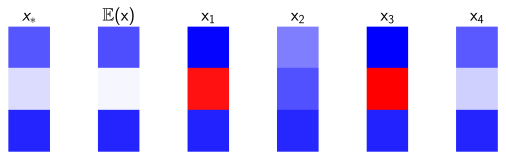

In [7]:
# Plot of true solution, mean and samples
rvdict = {"$x_*$" : x, 
          "$\mathbb{E}(\mathsf{x})$" : x_rv.mean, 
          "$\mathsf{x}_1$" : x_samples[0], 
          "$\mathsf{x}_2$" : x_samples[1], 
          "$\mathsf{x}_3$" : x_samples[2],
          "$\mathsf{x}_4$" : x_samples[3]}
vmin = np.min([np.min(mat) for mat in list(rvdict.values())])
vmax = np.max([np.max(mat) for mat in list(rvdict.values())])

fig, axes = plt.subplots(nrows=1, ncols=2 + n_samples, figsize=(8, 2.5), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv[:, np.newaxis], vmin=vmin, vmax=vmax, cmap="bwr")
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

Here, the probabilistic linear solver has identified the third component of the solution already with a high degree of confidence, while there is still some uncertainty about the first two left due to early termination.

### Encoding Prior Knowledge

If we have prior knowledge about the problem setting, we can encode this into a PN method by specifying a prior distribution on the input. For this problem we observe that the matrix $A$ is symmetric. Additionally, suppose we are given an approximate inverse of the system matrix. 

In [8]:
# Approximate inverse of A
Ainv_approx = np.array([[ 0.2  , -0.18, -0.015],
                        [-0.18 ,  0.7 , -0.03 ],
                        [-0.015, -0.03,  0.20 ]])
print(A @ Ainv_approx)

[[1.125  0.02   0.0275]
 [0.0325 1.025  0.01  ]
 [0.0275 0.005  1.07  ]]


For this problem we encode the symmetry of the system matrix and its inverse by using symmetric matrix-variate normal distributions as priors. Realizations of these priors are symmetric matrices. Since there is no stochasticity in the problem definition we choose a highly concentrated symmetric prior over $A$. This codifies our certainty about (multiplications with) $A$. For the prior over the inverse we choose the approximate inverse from above as a mean.

In [10]:
from probnum import randvars, linops

# Prior distribution(s)
A0 = randvars.Normal(
    mean=A, cov=linops.SymmetricKronecker(10 ** -6 * linops.Identity(A.shape[0]))
)
Ainv0 = randvars.Normal(
    mean=Ainv_approx, cov=linops.SymmetricKronecker(0.1 * linops.Identity(A.shape[0]))
)

We now solve the problem again, but this time we also pass the prior distributions to the solver.

In [11]:
# Solve linear system with limited computational budget and prior knowledge
x_rv, _, _, info = pn.linalg.problinsolve(A, b, A0=A0, Ainv0=Ainv0, maxiter=2)
print(info)

{'iter': 2, 'maxiter': 2, 'resid_l2norm': 0.00014783150371253874, 'trace_sol_cov': 0.007808118710123992, 'conv_crit': 'maxiter', 'rel_cond': None}


/home/jwenger/Documents/research/probabilistic_numerics/code/probnum/src/probnum/linalg/linearsolvers/matrixbased.py:548: UserWarning: Iteration terminated. Solver reached the maximum number of iterations.
  warnings.warn(


### Examining the Posterior

We now take another look at the uncertainty in the solution, given prior knowledge about the inverse.

In [12]:
# Covariance of solution representing uncertainty
print(f"Covariance matrix: \n{x_rv.cov.todense()}")

Covariance matrix: 
[[0.00037817 0.0015451  0.00064998]
 [0.0015451  0.00631279 0.00265563]
 [0.00064998 0.00265563 0.00111716]]


In [13]:
# Sample from output random variable
x_samples = x_rv.sample(n_samples)

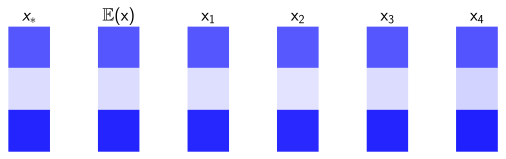

In [14]:
# Plot of true solution, mean and samples
rvdict = {"$x_*$" : x, 
          "$\mathbb{E}(\mathsf{x})$" : x_rv.mean, 
          "$\mathsf{x}_1$" : x_samples[0], 
          "$\mathsf{x}_2$" : x_samples[1],
          "$\mathsf{x}_3$" : x_samples[2],
          "$\mathsf{x}_4$" : x_samples[3]}

fig, axes = plt.subplots(nrows=1, ncols=2 + n_samples, figsize=(8, 2.5), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv[:, np.newaxis], vmin=vmin, vmax=vmax, cmap="bwr")
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

We observe that after the same number of steps in our algorithm all components are approximately identified and the uncertainty in the output is much lower. 

_Remark:_ The reader familiar with linear solvers might recognize that the prior on the inverse plays a similar role to the preconditioner for classic linear solvers.